# Neural Network for Regression
In the previous homework you implemented a linear regression network. In this exercise, we will solve the same problem with a neural network instead, to leverage the power of Deep Learning.

We will implement our neural networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build networks with different architectures.
  

In [1]:
# As usual, a bit of setup

from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1. Load your data
We apply the same dataloading and preprocessing steps as in the previous exercise.

In [2]:
target_column = 'SalePrice'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
housing_file_path = os.path.join(root_path, "housing_train.csv")
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

0it [00:00, ?it/s]

 81%|█████████████████████████████████████████████████████████▉              | 73728/91571 [00:00<00:00, 551029.30it/s]

In [3]:
df = train_dataset.df
target_column = 'SalePrice'
# Select only 2 features to keep plus the target column.
selected_columns = ['GrLivArea','GarageArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn

In [4]:
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


98304it [00:20, 551029.30it/s]                                                                                         

# 2. Build your Model
Now we want to build our model. But let's first construct the building blocks we want to use. We will define the forward and backward pass for an affine layer and a Sigmoid activation function

## 2.1 Affine Layer

Open the file `exercise_code/networks/layer.py` and implement the `affine_forward` and the `affine_backward` function. Remember, and affine layer computes a function of

$$\mathbf{z} = \mathbf{W} \mathbf{x}$$

To check the correctness of your implementation, we will again use numeric gradient checking:

$$ \frac {df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

Once you are done you can test your implementaion by running the following:

In [15]:
a=np.random.rand(20,20,8,6,4)


In [17]:
a.shape

(20, 20, 8, 6, 4)

In [18]:
s=a.shape[:2]

In [19]:
s

(20, 20)

In [20]:
if a.ndim>2 : s = s+ (-1,)

In [22]:
a.shape[:2] + (-1,)

(20, 20, -1)

In [21]:
s

(20, 20, -1)

In [ ]:
b=a.reshape(s)

In [30]:
# Test the affine function
from exercise_code.tests.layer_tests import *
print(AffineLayerTest()())

AffineForwardTest passed.
AffineBackwardTestDx passed.
AffineBackwardTestDw passed.
AffineBackwardTestDb passed.
Congratulations you have passed all the unit tests!!! Tests passed: 4/4
(0, 4)


## 2.2 Sigmoid layer:
Implement the forward pass for the sigmoid activation function in the `sigmoid_forward` function and the backward pass in `sigmoid_backward`.

$$ y = \sigma(z) = \frac{1}{1+\mathrm{exp}(-z)}, $$

Test your implementation using the following:

In [31]:
# Test the sigmoid function

print(SigmoidTest()())

SigmoidForwardTest passed.
SigmoidBackwardTest passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
(0, 2)


## 2.3 Two-layer regression network
Now that you have all the necessary building block, let's build your first neural network.

Open the file `exercise_code/networks/regression_net.py` and complete the implementation of the `RegressionNet` class. Specifically, you again need co complete the `forward` and `backward` functions. You can run the cell below to test your implementation.

In [33]:
from exercise_code.tests.regression_net_tests import test_regression_net
from exercise_code.networks.regression_net import RegressionNet
test_regression_net(RegressionNet)

RegressionNetForwardTest passed.
Method forward() correctly implemented. Tests passed: 1/1
RegressionNetBackwardTest passed.
Class RegressionNet correctly implemented. Tests passed: 2/2
Score: 100/100


100

# 3. Optimizer & Loss Function
We have now implemented:
- [x]  A dataloader
- [x]  A loss function
- [x]  A model
- [ ]  An optimizer
- [ ]  A loss function

The only things missing in out Deep Learning pipeline are an optimizer and a loss function. Since you already implemented SGD and MSE in last weeks' exercise, we will give them to you this time. Have a look at their implementations in `exercise_code/networks/optimizer.py` and `exercise_code/networks/loss.py`.

In [34]:
from exercise_code.networks.optimizer import SGD
from exercise_code.networks.loss import MSE, L1

# 4. Solver
Now that we have everything together, let's update our solver from exercise_04 and finally start training our model.

Open the file `exercise_code/solver.py` and read through it to familiarize yourself with the API. In the `train` and `_step` functions, you can see all of the components you implemented in the last exercises working together. Now, run the solver to train your model.

We provide you with a default set of hyperparameters here as hyperparameter search is not the scope of this exercise. However, you can still play around with those values and see how the training performance changes. Especially the `std` which is the standard deviation of the gaussian distribution used to initialize the weights of your model is very sensitive.

In [35]:
from exercise_code.networks.regression_net import RegressionNet
from exercise_code.solver import Solver

batch_size = 4
lr = 1e-3
hidden_size = 100
std = 1.
epochs = 20

model = RegressionNet(input_size=2, hidden_size=hidden_size, std=std)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr, loss_func=MSE(), optimizer=SGD)

# add test data to test before training
X_test = [test_dataset[i]['features'] for i in range((len(test_dataset)))]
X_test = np.stack(X_test, axis=0)
y_test = [test_dataset[i]['target'] for i in range((len(test_dataset)))]
y_test = np.stack(y_test, axis=0)



y_out = solver.get_dataset_prediction(test_dataloader)
l1_loss = L1()
mse_loss = MSE()
print("L1 loss on test set BEFORE training: {:,.0f}".format(l1_loss(rescale(y_out), rescale(y_test))[0].mean() ))
print("MSE loss on test set BEFORE training: {:,.0f}".format(mse_loss(rescale(y_out), rescale(y_test))[0].mean() ))




solver.train(epochs=epochs)

y_out, _ = model(X_test)
l1_loss = L1()
mse_loss = MSE()
print("L1 loss on test set AFTER training: {:,.0f}".format(l1_loss(rescale(y_out), rescale(y_test))[0].mean() ))
print("MSE loss on test set AFTER training: {:,.0f}".format(mse_loss(rescale(y_out), rescale(y_test))[0].mean() ))


L1 loss on test set BEFORE training: 1,686,081
MSE loss on test set BEFORE training: 2,866,170,408,126
(Epoch 1 / 20) train loss: 5.561933; val loss: 5.606161
(Epoch 2 / 20) train loss: 0.269933; val loss: 0.067703
(Epoch 3 / 20) train loss: 0.062422; val loss: 0.054788
(Epoch 4 / 20) train loss: 0.051043; val loss: 0.044551
(Epoch 5 / 20) train loss: 0.041997; val loss: 0.036434
(Epoch 6 / 20) train loss: 0.034802; val loss: 0.029996
(Epoch 7 / 20) train loss: 0.029075; val loss: 0.024888
(Epoch 8 / 20) train loss: 0.024513; val loss: 0.020835
(Epoch 9 / 20) train loss: 0.020877; val loss: 0.017616
(Epoch 10 / 20) train loss: 0.017975; val loss: 0.015060
(Epoch 11 / 20) train loss: 0.015656; val loss: 0.013028
(Epoch 12 / 20) train loss: 0.013802; val loss: 0.011412
(Epoch 13 / 20) train loss: 0.012317; val loss: 0.010126
(Epoch 14 / 20) train loss: 0.011125; val loss: 0.009102
(Epoch 15 / 20) train loss: 0.010167; val loss: 0.008285
(Epoch 16 / 20) train loss: 0.009396; val loss: 0.0

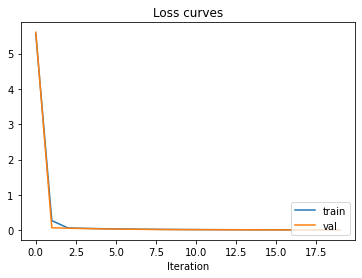

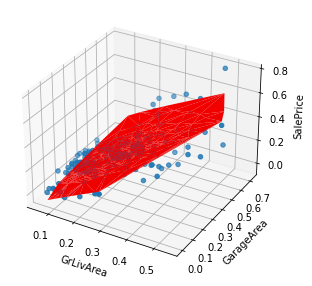

In [36]:
# # Run this cell to visualize your training and validation loss and your prediction
y_out = solver.get_dataset_prediction(test_dataloader)


plt.title('Loss curves')
plt.plot(solver.train_loss_history, '-', label='train')
plt.plot(solver.val_loss_history, '-', label='val')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.show()

if np.shape(X_test)[1]==1:
    plt.scatter(X_test, y_test, label = "Ground Truth")
    inds = X_test.argsort(0).flatten()
    plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.show()
else:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    first_feature = X_test[:, 0]
    second_feature = X_test[:, 1]
    salePrice = y_test[:, 0]
    
    salePricePred = y_out[:, 0]
    ax.plot_trisurf(first_feature, second_feature, salePricePred, linewidth=0, antialiased=True,color ="red")

    ax.scatter(first_feature, second_feature, salePrice)
  
    ax.set_xlabel(selected_columns[0])
    ax.set_ylabel(selected_columns[1])
    ax.set_zlabel(selected_columns[2])
    plt.tight_layout()
    plt.show()
    

## Save the model for submission

Simply save your objects using the following cell. This will save them to a pickle file `models/two_layer_regression.p`.

In [37]:
from exercise_code.tests import save_pickle

save_pickle(
    data_dict={
        "Regression_Net": RegressionNet
    },
    file_name="two_layer_regression.p"
)

# Submission Goals

- Goal: Successfully implement the forward and backward pass of a two layer regression neural network
- Test cases:
  1. Does `forward()` and `backward()` of your 2 layer regression neural net return the correct value and data type?
- Reachable points [0, 100]: 0 if not implemented, 100 if all tests passed, 50 per passed test
- Threshold to clear exercise: 100
- Submission start: __May 22, 2020 12.00__
- Submission deadline : __May 27, 2020 23.59__ 
- You can make multiple submission uptil the deadline. Your __best submission__ will be considered for bonus